**Ingredientes: Karim Saud, Benjamín Tardy D.**

In [1]:
from functools import reduce
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection as LC
from mpl_toolkits import mplot3d
import time

**Comentario:** El BBM según la bibliografía corre hacia atrás en el tiempo, sin embargo, por simplicidad y dado que en ley es lo mismo, para lo que sigue los BBM son construidos hacia adelante y parados en cierto tiempo $T_0$. Esto equivale a partir en $T_0$ y correrlos hacia atrás hasta $0$.

In [2]:
# Construye una rama del BBM usando Donsker. K representa el número máximo de pasos,
# y step representa el tamaño de cada paso. Corre un reloj exponencial que determina
# en qué momento se detiene el MB.
def branch(K,step):
    l = int(np.random.exponential()/step) + 1
    if l > K:
        l = K
        normal = np.random.normal(0,step,l)
        B = np.zeros(l+1)
        for i in range(l):
            B[i+1] = B[i] + normal[i]
    else:
        normal = np.random.normal(0,step,l)
        B = np.zeros(l+1)
        for i in range(l):
            B[i+1] = B[i] + normal[i]
    return B, l

# Usando la función branch, construye un BBM con Ko pasos y hasta tiempo To.
# La definición es recursiva y va creando un diccionario llamado brbrmo que le asigna,
# a cada paso del tiempo, una lista de tuplas (x,p) donde x es la posición de una de las
# ramas en dicho tiempo y p es su padre del tiempo anterior.
# La información sobre los padres de cada punto permite usar esta función para reconstruir
# el BBM y así, por ejemplo, graficar.
def BBM(To,Ko):
    step = To/Ko # tamaño del paso
    brbrmo = dict((i,[]) for i in range(Ko+1))
    brbrmo[0] = [(0,None),] # el primer punto no tiene padre
    def BBMrec(x0,K,brbrmo,Ko,step):
        B,l = branch(K,step) # Corre una rama con tamaño máximo K
        x = x0 # x representa el 'valor actual'
        for i in range(1,l+1):
            brbrmo[Ko-K+i].append((x0 + B[i],x)) # Se 'pega' la rama B al BBM en construcción, guardando el padre
            x = x0 + B[i]
        if l < K: # Si la rama no llegó a tiempo To, se ramifica y sigue la recursión.
            brbrmo = BBMrec(x,K-l,brbrmo,Ko,step)
            brbrmo = BBMrec(x,K-l,brbrmo,Ko,step)
        return brbrmo
    return BBMrec(0,Ko,brbrmo,Ko,step)

# Usa BBM para aproximar soluciones de KPP con g para la condición de borde, calculando para
# puntos en [0,T]x[x1,x2] con kt+1 y kx+1 representando la cantidad de puntos con los que se
# discretiza el tiempo y espacio respectivamente.
# Se usan los mismos N BBMs para todos los puntos.
def simSol(g,T,x1,x2,kt,kx,N):
    bbms = []
    for i in range(N): # Se simulan N BBMs.
        bbms.append(BBM(T,kt))
    Xs = [x1 + i*(x2-x1)/kx for i in range(kx+1)]
    
    u = np.zeros((kt+1,kx+1))
    for j in range(0,kx+1):
        x = Xs[j]
        u[0,j] = g(x)
        for l in range(1,kt+1):
            for i in range(N):
                u[l,j] += reduce(lambda a,b: a*g(x+b[0]),bbms[i][l],1)/N
                
                # Posible versión con variables antitéticas
                # u[l,j] += reduce(lambda a,b: a*g(x+b),bbms[i][l],1)/(2*N)
                # u[l,j] += reduce(lambda a,b: a*g(x-b),bbms[i][l],1)/(2*N)
    
    return u,bbms,T,x1,x2

# Función para graficar un bbm de parámetros To, Ko.
def plotBBM(bbm,To,Ko):
    print(len(bbm[Ko]))
    segments = []
    for i in range(1,Ko + 1):
        for par in bbm[i]:
            segments.append([(To*(i-1)/Ko, 13*par[1]), (To*i/Ko, 13*par[0])])
    return segments
    # fig, ax = plt.subplots()
    # ax.add_collection(lc)
    # ax.autoscale()
    # ax.set_aspect('equal', adjustable='box')
    

28


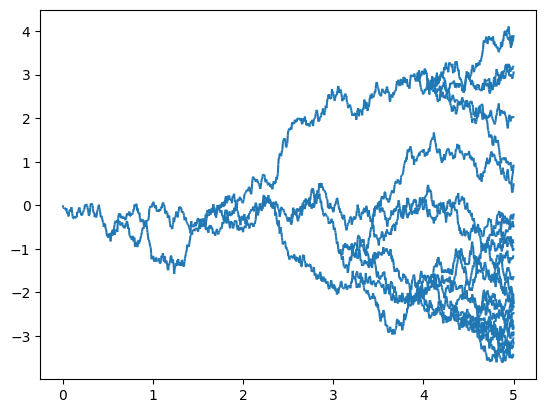

In [ ]:
To = 5
Ko = 1000
brbrmo = BBM(To,Ko)
fig, ax = plt.subplots()
ax.add_collection(LC(plotBBM(brbrmo,To,Ko)))
ax.autoscale()
#ax.set_aspect('equal', adjustable='box')

In [ ]:
# Solución teórica
# obtenida de: Int. J. Non-Linear Mechanics, Vol. 31, No. 3, pp. 329-338, 1996
sig1 = 2/np.sqrt(3)
lam1 = 5*np.sqrt(3)/6
def g(x):
    return 1 - ( 1 + (np.sqrt(2)-1)*np.exp(-sig1*x/2) )**(-2)

def u(t,x):
    return 1 - ( 1 + (np.sqrt(2)-1)*np.exp(-sig1*(x + lam1*t)/2) )**(-2)


# Parámetros
kt = 400
kx = 200
T = 4
x1 = -10
x2 = 10
Ts = np.linspace(0, T, kt+1)
Xs = np.linspace(x1, x2, kx+1)
X,Y = np.meshgrid(Ts,Xs,indexing='ij')
N = 200

# Realización de la simulación
start=time.time_ns()
usim = simSol(g,T,x1,x2,kt,kx,N)
elapsed = time.time_ns() - start
print(elapsed/10**9)

# Valores Teóricos
z = np.array([u(Ts[i],Xs[j]) for i in range(kt+1) for j in range(kx+1)])
Z = z.reshape((kt+1, kx+1))
# Valores simulados
Zsim = usim[0]

903.765566815


0.022749633956868246


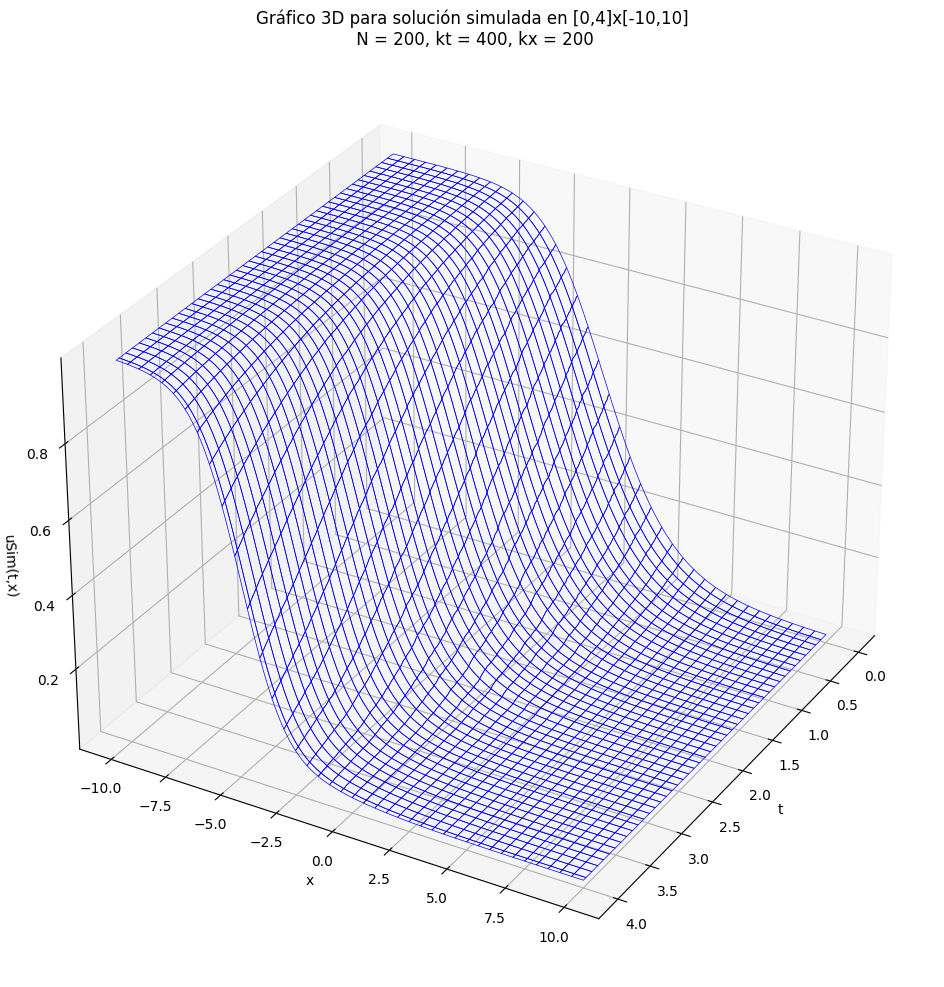

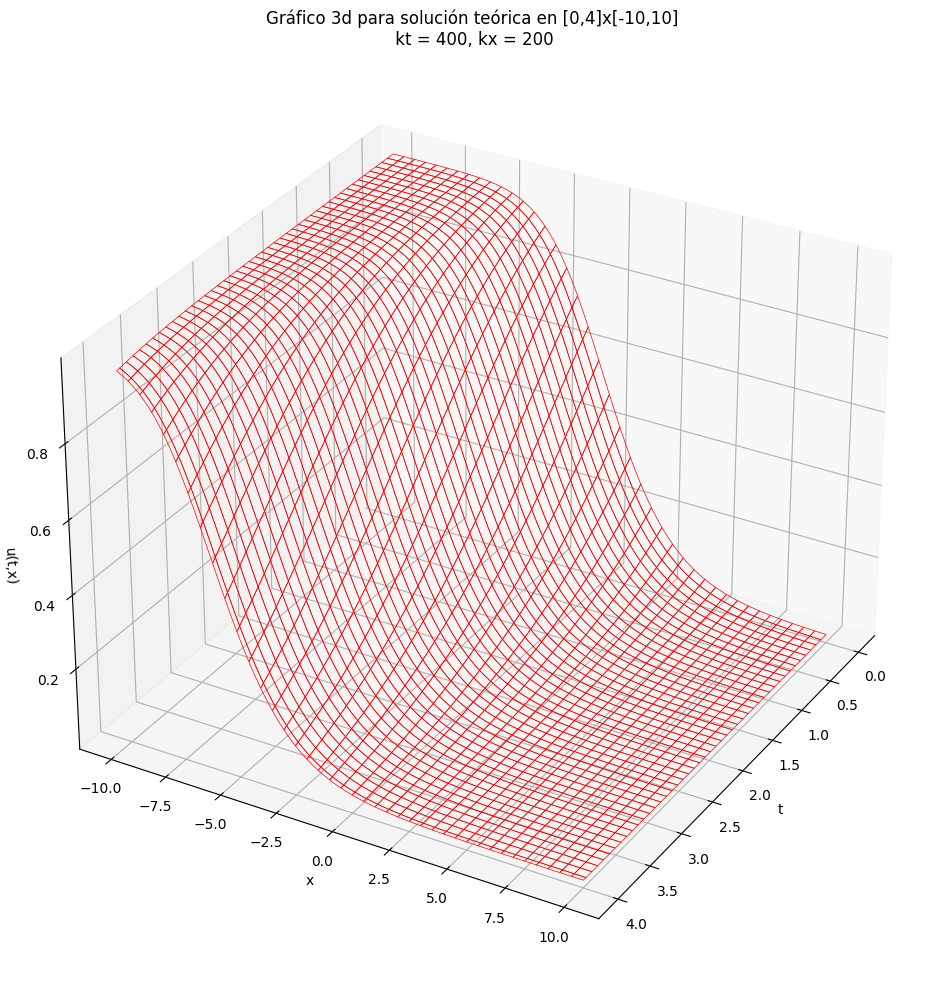

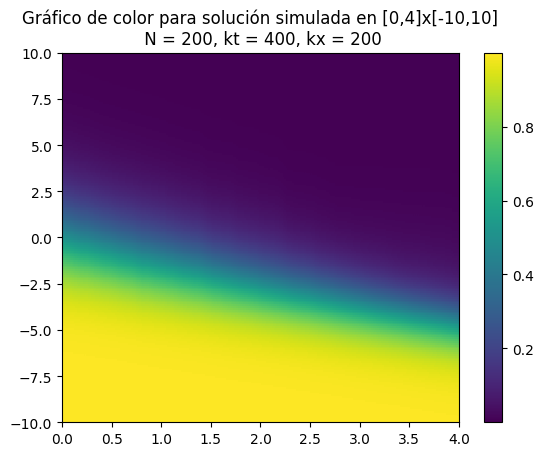

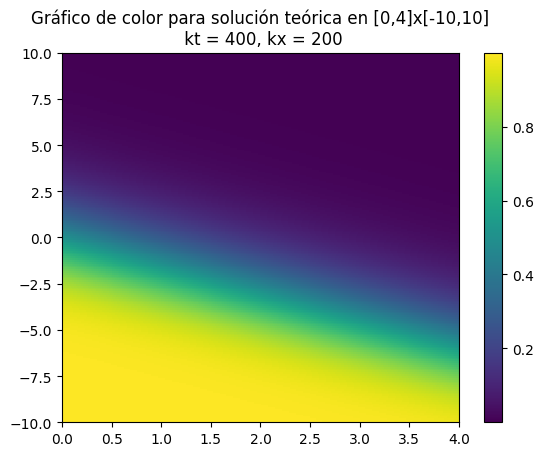

In [ ]:
plt.figure(figsize=(15,12))
ax = plt.axes(projection ='3d')
ax.set_title(f'Gráfico 3D para solución simulada en [0,{T}]x[{x1},{x2}]\n N = {N}, kt = {kt}, kx = {kx}')
ax.plot_surface(X,Y,Zsim, linewidth=0.5,alpha=0, edgecolors='b')
ax.view_init(azim=30,elev=30)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('uSim(t,x)')


plt.figure(figsize=(15,12))
ax = plt.axes(projection ='3d')
ax.set_title(f'Gráfico 3d para solución teórica en [0,{T}]x[{x1},{x2}]\n kt = {kt}, kx = {kx}')
ax.plot_surface(X,Y,Z, linewidth=0.5,alpha=0, edgecolors='r')
ax.view_init(azim=30,elev=30)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(t,x)')


fig, ax = plt.subplots()
imzs = ax.imshow(np.transpose(Zsim),extent=[0,T,x1,x2],aspect='auto',origin='lower',interpolation='none')
ax.set_title(f'Gráfico de color para solución simulada en [0,{T}]x[{x1},{x2}]\n N = {N}, kt = {kt}, kx = {kx}')
fig.colorbar(imzs,ax=ax)

fig, ax = plt.subplots()
imz = ax.imshow(np.transpose(Z),extent=[0,T,x1,x2],aspect='auto',origin='lower',interpolation='none')
ax.set_title(f'Gráfico de color para solución teórica en [0,{T}]x[{x1},{x2}]\n kt = {kt}, kx = {kx}')
fig.colorbar(imz,ax=ax)

# plt.figure(figsize=(16,9))
# plt.title(f'Gráfico de color para solución teórica en [0,{T}]x[{x1},{x2}]\n kt = {kt}, kx = {kx}')
# plt.imshow(np.transpose(Z),extent=[0,T,x1,x2],aspect='auto',origin='lower',interpolation='none')
# plt.colorbar()

print(np.sum(np.abs(Z-Zsim))/((kx+1)*(kt+1)))

In [3]:
# Solución teórica
# obtenida de: Int. J. Non-Linear Mechanics, Vol. 31, No. 3, pp. 329-338, 1996
sig1 = 2/np.sqrt(3)
lam1 = 5*np.sqrt(3)/6
def g(x):
    return 1 - ( 1 + (np.sqrt(2)-1)*np.exp(-sig1*x/2) )**(-2)

def u(t,x):
    return 1 - ( 1 + (np.sqrt(2)-1)*np.exp(-sig1*(x + lam1*t)/2) )**(-2)


# Parámetros
kt = 150
kx = 200
T = 4
x1 = -10
x2 = 10
Ts = np.linspace(0, T, kt+1)
Xs = np.linspace(x1, x2, kx+1)
X,Y = np.meshgrid(Ts,Xs,indexing='ij')
N = 100


# Valores Teóricos
z = np.array([u(Ts[i],Xs[j]) for i in range(kt+1) for j in range(kx+1)])
Z = z.reshape((kt+1, kx+1))

tiempos = dict()
errores = dict()
usims = dict()
for N in [100,200,300,400,500,600]:
    start=time.time_ns()
    usim = simSol(g,T,x1,x2,kt,kx,N)
    tiempos[N] = time.time_ns() - start
    errores[N] = np.sum(np.abs(Z-usim[0]))/((kx+1)*(kt+1))
    usims[N] = usim


1.3185491995557146 50.575549199000164


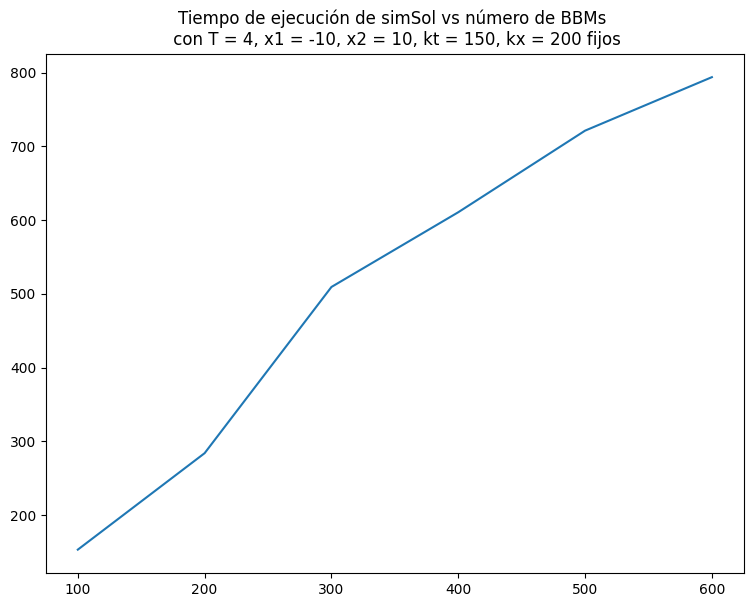

In [4]:
plt.figure(figsize=(9,6.75))
plt.title(f'Tiempo de ejecución de simSol vs número de BBMs \n con T = {T}, x1 = {x1}, x2 = {x2}, kt = {kt}, kx = {kx} fijos')
plt.plot(tiempos.keys(),list(map(lambda r: r/10**9,tiempos.values())))

m,n = np.polyfit(list(tiempos.keys()),list(map(lambda r: r/10**9,tiempos.values())),1)

print(m,n)

-3.4690939004427445e-07 0.02371089475130292


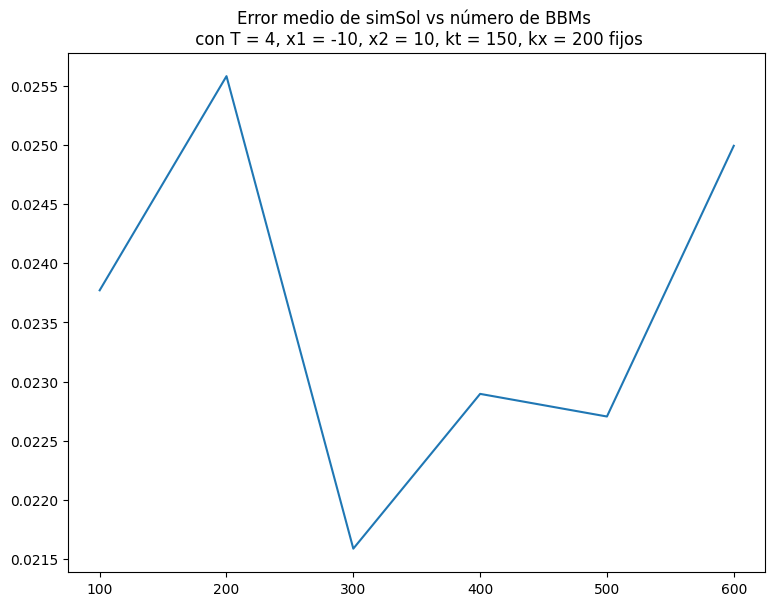

In [5]:
plt.figure(figsize=(9,6.75))
plt.title(f'Error medio de simSol vs número de BBMs \n con T = {T}, x1 = {x1}, x2 = {x2}, kt = {kt}, kx = {kx} fijos')
plt.plot(errores.keys(),errores.values())

m,n = np.polyfit(list(errores.keys()),list(errores.values()),1)
print(m,n)

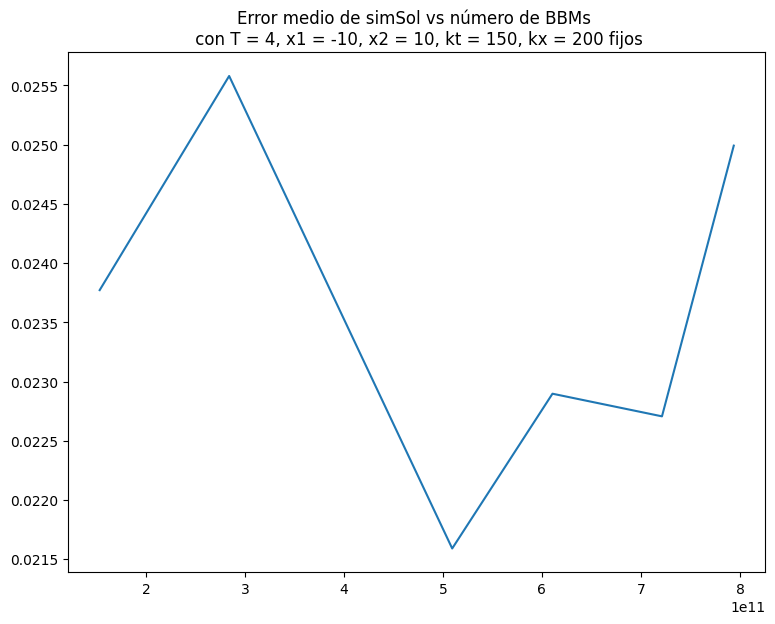

In [7]:
plt.figure(figsize=(9,6.75))
plt.title(f'Error medio de simSol vs número de BBMs \n con T = {T}, x1 = {x1}, x2 = {x2}, kt = {kt}, kx = {kx} fijos')
plt.plot(tiempos.values(),errores.values())

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=06d33d52-b080-4205-8e26-c5ce01e3028f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>